In [92]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.decomposition import PCA

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [93]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/synesthetes/participants.csv"
embeddings_subpath = "synesthetes_random_embeddings/full_embeddings.csv"
ukb_embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/isSynesthete_without_residualization.csv"
label = "isSynesthete"
max_iter = 2000
cv = 3

In [94]:
participants = pd.read_csv(participants_file, index_col=0)


In [95]:
participants.head()

,isSynesthete,NOM,DDN,IRM name,Date IRM,Âge,Sexe,Latéralité,Remarques,Code BV,Unnamed: 9,2=femme – 1=homme,0=droitier – 1=gaucher
participant_id,,,,,,,,,,,,,
mv_SYNESTHEX_3-Session1_S2_T1w,1,SARR,10/8/1996,Sujet01,28/2/2023,26.569863,2,0,NaN,3,NaN,NaN,NaN
mv_SYNESTHEX_S_Session1_S2_T1w,1,LEFR,14/12/1950,Sujet02,9/3/2023,72.282192,2,0,NaN,S,NaN,NaN,NaN
mv_SYNESTHEX_M_Session1_S2_T1w,1,FERN,NaN,Sujet03,NaN,23.680000,1,0,NaN,M,NaN,NaN,NaN
mv_SYNESTHEX_K_Session1_S2_T1w,1,DERO,27/6/1997,Sujet04,21/10/2023,26.334247,1,0,NaN,K,NaN,NaN,NaN
mv_SYNESTHEX_Sujet20_Session1_S2_T1w,1,DECH,NaN,Sujet05,NaN,21.110000,2,1,NaN,Sujet20,NaN,NaN,NaN


In [96]:
participants = participants[["isSynesthete", "Sexe", "Latéralité"]]

In [97]:
# participants[:] = participants.sample(frac=1).values

In [98]:
participants

,isSynesthete,Sexe,Latéralité
participant_id,,,
mv_SYNESTHEX_3-Session1_S2_T1w,1,2,0
mv_SYNESTHEX_S_Session1_S2_T1w,1,2,0
mv_SYNESTHEX_M_Session1_S2_T1w,1,1,0
mv_SYNESTHEX_K_Session1_S2_T1w,1,1,0
mv_SYNESTHEX_Sujet20_Session1_S2_T1w,1,2,1
mv_SYNESTHEX_Y_Session1_S2_T1w,1,1,0
mv_SYNESTHEX_Sujet25_Session1_S2_T1w,1,1,1
mv_SYNESTHEX_G_Session1_S2_T1w,1,2,0
mv_SYNESTHEX_D_Session1_S2_T1w,1,2,0


array([[<Axes: title={'center': 'isSynesthete'}>,
        <Axes: title={'center': 'Sexe'}>],
       [<Axes: title={'center': 'Latéralité'}>, <Axes: >]], dtype=object)

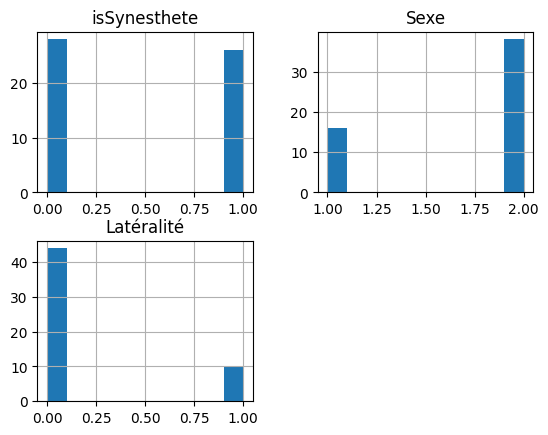

In [99]:
participants.hist()

In [100]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [101]:
model_paths = get_model_paths(path_champollion)

In [102]:
models_df = pd.DataFrame({"path":model_paths})

In [103]:
# df = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
# pca = PCA(n_components=1)
# df2 = pd.DataFrame(pca.fit_transform(df))
# df2.index = df.index
# df2


In [104]:
def compute(model_path, random_state):
    global embeddings
    global participants
    global results, X, Y, df2
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    ukb_emb = pd.read_csv(f"{model_path}/{ukb_embeddings_subpath}", index_col=0)
    
    # Classifies
    X = merged.drop([label], axis=1)
    Y = merged[[label]]

    # Makes PCA on UkBioBank
    # print(ukb_emb.shape)
    pca = PCA(n_components=3)
    pca.fit(ukb_emb)

    # Transforms in synesthete dataset
    df2 = pd.DataFrame(pca.transform(X))
    df2.index = X.index

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    p_value = results.f_pvalue
    f_value = results.fvalue
    predictions = results.predict(df2)

    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value)
    
    # Returns result
    return (region, predictions, Y)

In [105]:
participants.dtypes

isSynesthete    int64
Sexe            int64
Latéralité      int64
dtype: object

In [106]:
result = pd.DataFrame({})
for random_state in range(1):

    # Computes AUC
    for model_path in model_paths:
        ret = compute(model_path, random_state)
        f = ret[1].to_frame().T
        f.insert(0, "region", [ret[0]])
        result = pd.concat([result, f]).reset_index(drop=True)
        Y = ret[2]

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
1.8215573662761748
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
1.8841257351345315
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
0.4535478098244833
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
0.12150318667927851
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
0.7486267314099394
Treating S.T.s.-S.GSM._left: STs-SGSM_left/13-57-40_59 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STs-SGSM_left/13-

In [107]:
result

,region,mv_SYNESTHEX_3-Session1_S2_T1w,mv_SYNESTHEX_S_Session1_S2_T1w,mv_SYNESTHEX_M_Session1_S2_T1w,mv_SYNESTHEX_K_Session1_S2_T1w,mv_SYNESTHEX_Sujet20_Session1_S2_T1w,mv_SYNESTHEX_Y_Session1_S2_T1w,mv_SYNESTHEX_Sujet25_Session1_S2_T1w,mv_SYNESTHEX_G_Session1_S2_T1w,mv_SYNESTHEX_D_Session1_S2_T1w,...,mv_SYNESTHEX_8-Session1_S2_T1w,mv_SYNESTHEX_L_Session1_S2_T1w,mv_SYNESTHEX_E_Session1_S2_T1w,mv_SYNESTHEX_Sujet19_Session1_S3_T1w,mv_SYNESTHEX_Sujet23_Session1_S3_T1w,mv_SYNESTHEX_Sujet24_Session1_S2_T1w,mv_SYNESTHEX_Sujet28_Session1_S2_T1w,mv_SYNESTHEX_Sujet21_Session1_S2_T1w,mv_SYNESTHEX_Sujet10_Session2_S14_T1w,mv_SYNESTHEX_Sujet15_Session2_S13_T1w
0,S.C.-sylv._left,0.373492,0.306504,0.215209,0.623594,0.358301,0.624081,0.518250,0.685440,0.585910,...,0.289179,0.539972,0.288456,0.376481,0.433153,0.347993,0.612375,0.325346,0.463773,0.661217
1,S.C.-sylv._left,0.417685,0.431503,0.211590,0.563741,0.278568,0.539487,0.453098,0.642837,0.612523,...,0.346224,0.649659,0.232442,0.384388,0.237132,0.295548,0.556743,0.433086,0.521639,0.594343
2,S.F.inter.-S.F.sup._left,0.542314,0.601360,0.494141,0.579315,0.478834,0.516412,0.514176,0.584517,0.489335,...,0.390980,0.548973,0.448232,0.553154,0.568942,0.405026,0.438319,0.306277,0.597863,0.576533
3,S.T.i.-S.T.s.-S.T.pol._right,0.523972,0.445371,0.446777,0.463319,0.544843,0.464316,0.492409,0.523401,0.475697,...,0.503622,0.458882,0.414146,0.494246,0.474607,0.483341,0.463419,0.480910,0.480845,0.429909
4,F.Coll.-S.Rh._right,0.519310,0.362930,0.334994,0.553849,0.547431,0.576381,0.623687,0.600368,0.432139,...,0.474001,0.537240,0.411199,0.365098,0.475628,0.496269,0.572103,0.375747,0.452164,0.380701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,S.C.-S.Po.C._left,0.530836,0.402883,0.374021,0.498936,0.510788,0.450280,0.410603,0.444270,0.536435,...,0.388540,0.526933,0.404624,0.431313,0.519132,0.398108,0.574983,0.541008,0.521817,0.529096
94,S.C.-S.Po.C._left,0.481914,0.451941,0.183834,0.537739,0.353656,0.433087,0.507420,0.672944,0.671013,...,0.512851,0.517735,0.294208,0.456946,0.340245,0.150039,0.634891,0.431131,0.604004,0.458817
95,S.C.-S.Po.C._left,0.398923,0.484099,0.177126,0.361462,0.330250,0.608887,0.466836,0.862954,0.721814,...,0.489165,0.544671,0.222000,0.450204,0.218524,0.203131,0.546440,0.219251,0.766874,0.426348
96,S.C.-S.Po.C._left,0.495726,0.350399,0.374709,0.521736,0.465591,0.451365,0.392571,0.550498,0.504164,...,0.443884,0.486456,0.429886,0.475108,0.532250,0.438146,0.588155,0.506150,0.548086,0.573634


In [108]:
ensemble = result.groupby("region").mean()

In [120]:
ensemble

,mv_SYNESTHEX_3-Session1_S2_T1w,mv_SYNESTHEX_S_Session1_S2_T1w,mv_SYNESTHEX_M_Session1_S2_T1w,mv_SYNESTHEX_K_Session1_S2_T1w,mv_SYNESTHEX_Sujet20_Session1_S2_T1w,mv_SYNESTHEX_Y_Session1_S2_T1w,mv_SYNESTHEX_Sujet25_Session1_S2_T1w,mv_SYNESTHEX_G_Session1_S2_T1w,mv_SYNESTHEX_D_Session1_S2_T1w,mv_SYNESTHEX_X_Session1_S2_T1w,...,mv_SYNESTHEX_8-Session1_S2_T1w,mv_SYNESTHEX_L_Session1_S2_T1w,mv_SYNESTHEX_E_Session1_S2_T1w,mv_SYNESTHEX_Sujet19_Session1_S3_T1w,mv_SYNESTHEX_Sujet23_Session1_S3_T1w,mv_SYNESTHEX_Sujet24_Session1_S2_T1w,mv_SYNESTHEX_Sujet28_Session1_S2_T1w,mv_SYNESTHEX_Sujet21_Session1_S2_T1w,mv_SYNESTHEX_Sujet10_Session2_S14_T1w,mv_SYNESTHEX_Sujet15_Session2_S13_T1w
region,,,,,,,,,,,,,,,,,,,,,
CINGULATE_left,0.563603,0.467602,0.374357,0.401184,0.547342,0.508866,0.620784,0.610175,0.568031,0.604910,...,0.541786,0.535103,0.348230,0.413899,0.455455,0.379139,0.557575,0.337589,0.603366,0.537491
CINGULATE_right,0.547674,0.439568,0.550540,0.488408,0.555055,0.498203,0.426209,0.552151,0.334457,0.426038,...,0.504654,0.468225,0.502680,0.395742,0.418934,0.471037,0.320549,0.513386,0.448051,0.503875
F.C.L.p.-S.GSM._left,0.469960,0.484699,0.472817,0.303590,0.463327,0.362420,0.445055,0.585548,0.664277,0.523716,...,0.588562,0.410454,0.499906,0.438542,0.358863,0.518461,0.304785,0.478306,0.544338,0.510731
F.C.L.p.-S.GSM._right,0.536098,0.414763,0.472596,0.504256,0.546828,0.488611,0.438913,0.528157,0.430833,0.488834,...,0.497180,0.442443,0.553037,0.411565,0.523646,0.566997,0.490135,0.416271,0.457007,0.540203
F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,0.483514,0.502849,0.477322,0.326359,0.465708,0.426166,0.483629,0.723318,0.614599,0.508788,...,0.510449,0.318988,0.458374,0.445038,0.269577,0.546344,0.337917,0.558391,0.494296,0.514154
F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,0.585217,0.425867,0.467683,0.478943,0.590942,0.489685,0.406886,0.521153,0.426892,0.495482,...,0.523570,0.472585,0.535228,0.451814,0.487941,0.584101,0.453028,0.448475,0.443257,0.521646
F.C.M.post.-S.p.C._left,0.585744,0.277871,0.279964,0.491258,0.542053,0.525020,0.649995,0.701883,0.711785,0.691258,...,0.459842,0.439896,0.368327,0.449782,0.484765,0.198645,0.637942,0.347948,0.537074,0.644463
F.C.M.post.-S.p.C._right,0.591273,0.388884,0.554113,0.559455,0.572722,0.531533,0.554438,0.559398,0.565609,0.520902,...,0.461429,0.396620,0.307056,0.678920,0.514616,0.371039,0.500074,0.516347,0.444627,0.453112
F.Coll.-S.Rh._left,0.270612,0.542212,0.679956,0.413831,0.510989,0.464145,0.628393,0.381540,0.671461,0.476613,...,0.368868,0.427801,0.572210,0.442494,0.570710,0.286164,0.486393,0.404638,0.526304,0.356495


In [109]:
res_ensemble = []
for row in ensemble.iterrows():
    df2 = row[1].copy().to_frame()
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y, df2)
    results = model.fit()
    res_ensemble.append((row[0], results.fvalue, results.f_pvalue))

In [110]:
res_ensemble

[('CINGULATE_left', 2.4489607360574315, 0.1236686581390682),
 ('CINGULATE_right', 0.8178472783090723, 0.36998116704459727),
 ('F.C.L.p.-S.GSM._left', 1.5139180823794345, 0.2240792942894302),
 ('F.C.L.p.-S.GSM._right', 0.4613991425736656, 0.4999832930363246),
 ('F.C.L.p.-subsc.-F.C.L.a.-INSULA._left',
  2.14686835418568,
  0.14888164635413947),
 ('F.C.L.p.-subsc.-F.C.L.a.-INSULA._right',
  0.7075166263836956,
  0.40412096227502614),
 ('F.C.M.post.-S.p.C._left', 3.7179707126335666, 0.059298196044025725),
 ('F.C.M.post.-S.p.C._right', 1.9156095243934481, 0.17225331095487562),
 ('F.Coll.-S.Rh._left', 3.3609120361460496, 0.07248797156838303),
 ('F.Coll.-S.Rh._right', 2.3357154019990105, 0.13249752474176507),
 ('F.I.P._left', 1.1406936532127974, 0.29043907505362343),
 ('F.I.P._right', 6.904216980824388, 0.01127531406491278),
 ('F.P.O.-S.Cu.-Sc.Cal._left', 2.173796541277121, 0.14640815162331033),
 ('F.P.O.-S.Cu.-Sc.Cal._right', 0.33081997012863124, 0.567657193533218),
 ('Lobule_parietal_sup._

In [111]:
df = pd.DataFrame(res_ensemble, columns=['region', 'f_value', 'p_value'])

In [112]:
df

,region,f_value,p_value
0,CINGULATE_left,2.448961,0.123669
1,CINGULATE_right,0.817847,0.369981
2,F.C.L.p.-S.GSM._left,1.513918,0.224079
3,F.C.L.p.-S.GSM._right,0.461399,0.499983
4,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,2.146868,0.148882
5,F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,0.707517,0.404121
6,F.C.M.post.-S.p.C._left,3.717971,0.059298
7,F.C.M.post.-S.p.C._right,1.915610,0.172253
8,F.Coll.-S.Rh._left,3.360912,0.072488
9,F.Coll.-S.Rh._right,2.335715,0.132498


In [113]:
df['side'] = df['region'].str.split('_').str[-1]

In [114]:
df

,region,f_value,p_value,side
0,CINGULATE_left,2.448961,0.123669,left
1,CINGULATE_right,0.817847,0.369981,right
2,F.C.L.p.-S.GSM._left,1.513918,0.224079,left
3,F.C.L.p.-S.GSM._right,0.461399,0.499983,right
4,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,2.146868,0.148882,left
5,F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,0.707517,0.404121,right
6,F.C.M.post.-S.p.C._left,3.717971,0.059298,left
7,F.C.M.post.-S.p.C._right,1.915610,0.172253,right
8,F.Coll.-S.Rh._left,3.360912,0.072488,left
9,F.Coll.-S.Rh._right,2.335715,0.132498,right


In [115]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=-np.log10(0.05/56), color='black', linestyle='-')
    ax.barh(res[region_name], -np.log10(res[f2_value]), fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)


In [116]:
df.sort_values(by="f_value", ascending=False)

,region,f_value,p_value,side
53,S.T.s.br._right,12.762755,0.000773,right
42,S.Po.C._left,12.729136,0.000784,left
18,ORBITAL_left,9.412304,0.003419,left
27,S.F.inf.-BROCA-S.Pe.C.inf._right,7.508220,0.008396,right
38,S.Or.-S.Olf._left,7.372431,0.008968,left
11,F.I.P._right,6.904217,0.011275,right
24,S.C.-sylv._left,6.192285,0.016072,left
22,S.C.-S.Po.C._left,6.172256,0.016235,left
46,S.T.i.-S.T.s.-S.T.pol._left,5.964694,0.018031,left
48,S.T.s.-S.GSM._left,5.563210,0.022135,left


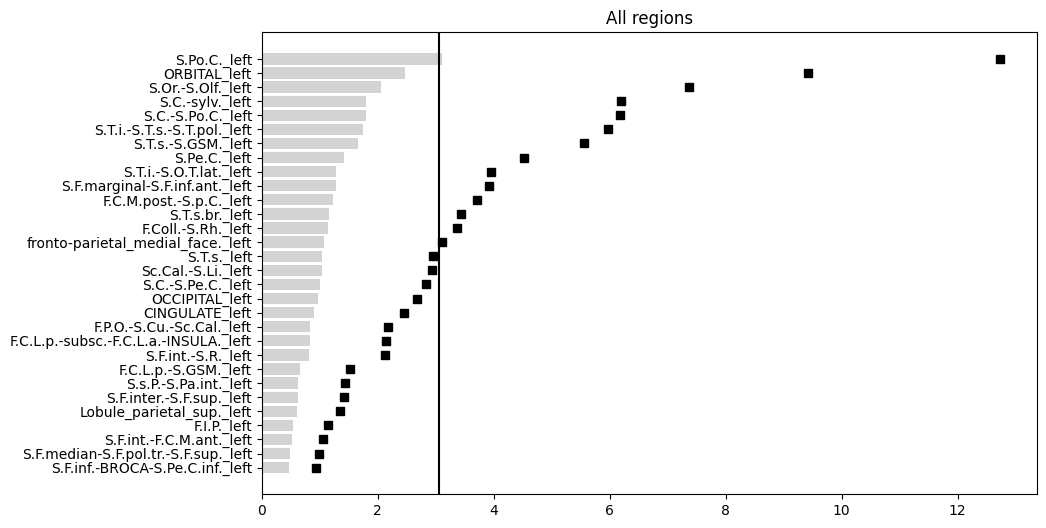

In [117]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

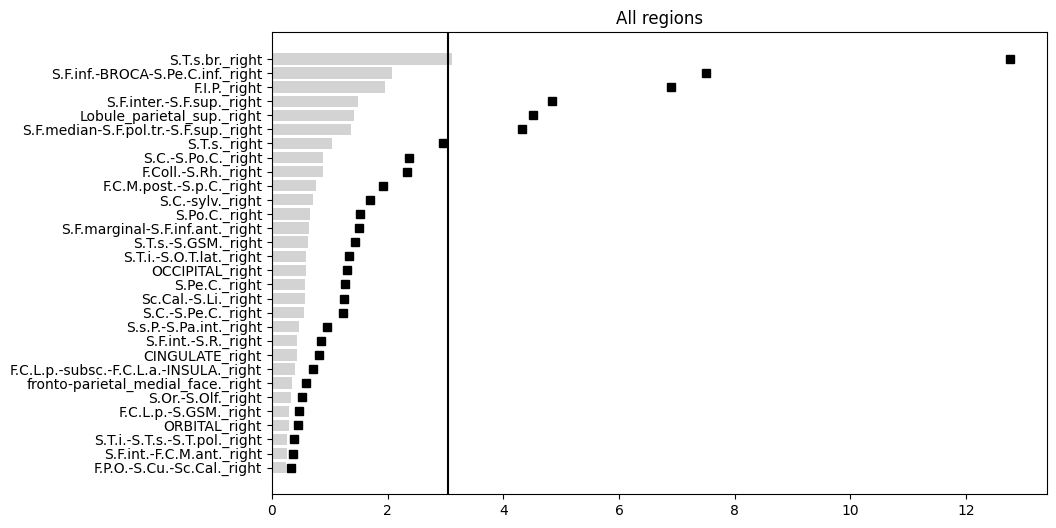

In [118]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "p_value", "p_value",  True, "All regions")
plt.show()

In [119]:
# df.to_csv(output_filename)